In [2]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold

from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [3]:
#trainデータの読み込み・目的変数と説明変数の分離
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")

train_x = train.drop(['label'],axis=1)
train_y = train['label']

#testデータの読み込み
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [4]:
#trainデータを4分割し、訓練用：バリデーションを3:1にする
kf = KFold(n_splits=4, shuffle=True, random_state=123)

tr_idx, va_idx = list(kf.split(train_x))[0]#index取得
tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

In [5]:
#画像pixel値を255で割って正規化・numpy配列に変換
tr_x, va_x = np.array(tr_x/255.0),np.array(va_x/255.0)

#正解ラベルをOne-Hot表現化
tr_y = to_categorical(tr_y,10)#numpy.ndarray
va_y = to_categorical(va_y,10)#numpy.ndarray

print(tr_x.shape,tr_y.shape,va_x.shape,va_y.shape)

(31500, 784) (31500, 10) (10500, 784) (10500, 10)


Counter({1: 4684,
         0: 4132,
         4: 4072,
         7: 4401,
         3: 4351,
         5: 3795,
         8: 4063,
         9: 4188,
         2: 4177,
         6: 4137})

<Axes: xlabel='label', ylabel='count'>

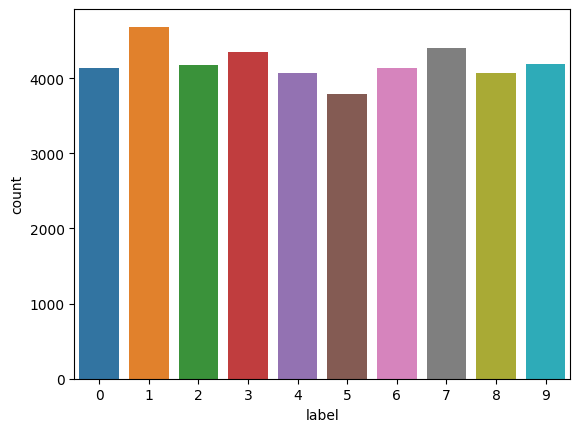

In [6]:
#0~9の各数字の枚数を調べる
count = Counter(train['label'])
display(count)
sns.countplot(x=train['label'])

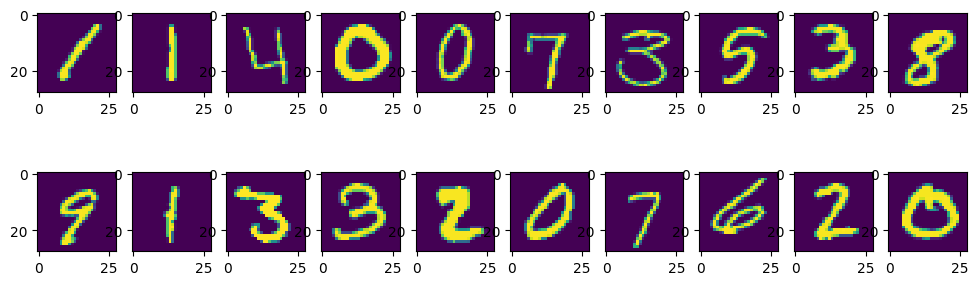

In [7]:
#手書きの数字データを描画する
plt.figure(figsize=(12,10))
x,y=10,5
for i in range(20):
    plt.subplot(y,x,i+1)
    plt.imshow(tr_x[i].reshape((28,28)),interpolation='nearest')#28*28にリサイズ
plt.show()

In [21]:
#NN第一層（隠れ層）の作成
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Activation, Dropout

# ニューラルネットワーク基盤のクラスSequentialを生成
model = Sequential()

# 入力層を含む最初の層を定義
model.add(
    Input(shape=(tr_x.shape[1],))  # 入力データの形状を指定
)
model.add(
    Dense(
        128,  # ニューロン数
        activation='sigmoid'  # 活性化関数: シグモイド（各クラスの信頼度を出す）
    )
)

In [9]:
#第2層（出力層）
model.add(
    Dense(
        10,  # ニューロン数
        activation='softmax'  # マルチクラス分類に適したsoftmaxを指定（各クラスの確率を出す）
    )
)

In [10]:
model.compile(
    #損失関数：クロスエントロピー誤差
    loss='categorical_crossentropy',
    optimizer='adam',
    #学習評価：正解率
    metrics=['accuracy']
)

In [13]:
#学習を実行
result = model.fit(
    tr_x,
    tr_y,
    epochs=5,#学習回数
    batch_size=100,#ミニバッチサイズ
    validation_data=(va_x,va_y),#検証用データの指定
    verbose=1#学習の進捗表示
)

Epoch 1/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6931 - loss: 1.1902 - val_accuracy: 0.8993 - val_loss: 0.3854
Epoch 2/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9056 - loss: 0.3529 - val_accuracy: 0.9175 - val_loss: 0.2897
Epoch 3/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9261 - loss: 0.2699 - val_accuracy: 0.9277 - val_loss: 0.2527
Epoch 4/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9349 - loss: 0.2331 - val_accuracy: 0.9350 - val_loss: 0.2195
Epoch 5/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9453 - loss: 0.1922 - val_accuracy: 0.9425 - val_loss: 0.2001


In [14]:
#テストデータの予測・提出
result = model.predict(test)

#最大値のインデックスを表示
print([x.argmax() for x in result[:5]])

#予測した数字をnumpy配列に代入
y_test = [x.argmax() for x in result]

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
[2, 0, 9, 9, 3]


In [15]:
submit_df = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
submit_df['Label'] = y_test
#submit_df.head(5)

submit_df.to_csv('submission.csv', index=False)

In [23]:
#パラメータチューニング

def prepare_data():#データ作成関数
    #trainデータの読み込み・目的変数と説明変数の分離
    train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
    train_x = train.drop(['label'],axis=1)
    train_y = train['label']

    #trainデータを4分割し、訓練用：バリデーションを3:1にする
    kf = KFold(n_splits=4, shuffle=True, random_state=123)
    tr_idx, va_idx = list(kf.split(train_x))[0]#index取得
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

    #画像pixel値を255で割って正規化・numpy配列に変換
    tr_x, va_x = np.array(tr_x/255.0),np.array(va_x/255.0)
    #正解ラベルをOne-Hot表現化
    tr_y = to_categorical(tr_y,10)#numpy.ndarray
    va_y = to_categorical(va_y,10)#numpy.ndarray

    return tr_x,tr_y,va_x,va_y

In [25]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
import numpy as np

# モデル構築を試行する関数
def objective(trial):
    # データを取得
    tr_x, tr_y, va_x, va_y = prepare_data()

    # モデルの構築
    model = Sequential()
    model.add(Input(shape=(tr_x.shape[1],)))

    # 第一層（ニューロン数の選択）
    n_units_first = trial.suggest_categorical('units_first', [500, 784])
    model.add(Dense(n_units_first, activation='relu'))
    model.add(Dropout(0.4))

    # 隠れ層の数を選択
    n_layers = trial.suggest_categorical('n_layers', ['none', 'one', 'two'])
    if n_layers == 'one':
        n_units_second = trial.suggest_categorical('units_second', [100, 200])
        model.add(Dense(n_units_second, activation='relu'))
    elif n_layers == 'two':
        n_units_second = trial.suggest_categorical('units_second', [100, 200])
        model.add(Dense(n_units_second, activation='relu'))
        n_units_third = trial.suggest_categorical('units_third', [25, 50])
        model.add(Dense(n_units_third, activation='relu'))

    # 出力層
    model.add(Dense(10, activation='softmax'))

    # オプティマイザの選択
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    optimizer = Adam() if optimizer_name == 'adam' else RMSprop()

    # モデルのコンパイル
    model.compile(
        optimizer=optimizer,
        loss=CategoricalCrossentropy(),
        metrics=['accuracy']
    )

    # ハイパーパラメータチューニング中の学習
    history = model.fit(
        tr_x, tr_y,
        epochs=10,
        batch_size=100,
        validation_data=(va_x, va_y),
        verbose=0
    )

    # 検証精度を最小化するようにスコアを設定（最大化したいので負符号）
    validation_acc = max(history.history['val_accuracy'])
    return -validation_acc

# Optunaのチューニング実行
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# 最適なパラメータとモデル
print("Best trial:")
print(study.best_trial.params)

[I 2025-01-26 10:04:24,168] A new study created in memory with name: no-name-ea453f9c-50fc-44f2-9f09-538d40f79530
[I 2025-01-26 10:04:56,505] Trial 0 finished with value: -0.9779999852180481 and parameters: {'units_first': 784, 'n_layers': 'one', 'units_second': 100, 'optimizer': 'adam'}. Best is trial 0 with value: -0.9779999852180481.
[I 2025-01-26 10:05:33,280] Trial 1 finished with value: -0.9792380928993225 and parameters: {'units_first': 784, 'n_layers': 'one', 'units_second': 200, 'optimizer': 'adam'}. Best is trial 1 with value: -0.9792380928993225.
[I 2025-01-26 10:06:00,153] Trial 2 finished with value: -0.977238118648529 and parameters: {'units_first': 500, 'n_layers': 'two', 'units_second': 200, 'units_third': 50, 'optimizer': 'rmsprop'}. Best is trial 1 with value: -0.9792380928993225.
[I 2025-01-26 10:06:25,793] Trial 3 finished with value: -0.9781904816627502 and parameters: {'units_first': 500, 'n_layers': 'two', 'units_second': 200, 'units_third': 25, 'optimizer': 'rms

Best trial:
{'units_first': 784, 'n_layers': 'one', 'units_second': 200, 'optimizer': 'rmsprop'}


In [ ]:
# さらに細かくチューニング
def objective2(trial):
    # データを取得
    tr_x, tr_y, va_x, va_y = prepare_data()

    # 第一層
    n_units_first = 784
    dropout_first = trial.suggest_float('dropout_first', 0.2, 0.4, step=0.05)#ドロップアウト率探索
    activation_first = trial.suggest_categorical('activation_first', ['tanh', 'relu'])#活性化関数探索
    model.add(Dense(n_units_first, activation=activation_first))
    model.add(Dropout(dropout_first))

    #第2層
    n_units_second = 200
    dropout_second = trial.suggest_float('dropout_second', 0.2, 0.4, step=0.05)#ドロップアウト率探索
    activation_second = trial.suggest_categorical('activation_second', ['tanh', 'relu'])#活性化関数探索
    model.add(Dense(n_units_second, activation=activation_second))
    model.add(Dropout(dropout_second))

    # 出力層
    model.add(Dense(10, activation='softmax'))

    # オプティマイザの選択
    optimizer_name = 'rmsprop'
    optimizer = Adam() if optimizer_name == 'adam' else RMSprop()

    # モデルのコンパイル
    model.compile(
        optimizer=optimizer,
        loss=CategoricalCrossentropy(),
        metrics=['accuracy']
    )


    batch_size = trial.suggest_categorical('batch_size', [100, 200])
    # ハイパーパラメータチューニング中の学習
    history = model.fit(
        tr_x, tr_y,
        epochs=10,
        batch_size=batch_size,
        validation_data=(va_x, va_y),
        verbose=0
    )

    # 検証精度を最小化するようにスコアを設定（最大化したいので負符号）
    validation_acc = max(history.history['val_accuracy'])
    return -validation_acc

# Optunaのチューニング実行
study = optuna.create_study(direction='minimize')
study.optimize(objective2, n_trials=100)

# 最適なパラメータとモデル
print("Best trial:")
print(study.best_trial.params)

[I 2025-01-26 11:44:35,548] A new study created in memory with name: no-name-76baea4b-e404-4f38-a4c1-551c8bf81c17
[I 2025-01-26 11:44:59,721] Trial 0 finished with value: -0.972095251083374 and parameters: {'dropout_first': 0.35000000000000003, 'activation_first': 'relu', 'dropout_second': 0.25, 'activation_second': 'tanh', 'batch_size': 100}. Best is trial 0 with value: -0.972095251083374.
[I 2025-01-26 11:45:27,627] Trial 1 finished with value: -0.9742857217788696 and parameters: {'dropout_first': 0.2, 'activation_first': 'relu', 'dropout_second': 0.4, 'activation_second': 'relu', 'batch_size': 200}. Best is trial 1 with value: -0.9742857217788696.
[I 2025-01-26 11:46:11,791] Trial 2 finished with value: -0.9749523997306824 and parameters: {'dropout_first': 0.35000000000000003, 'activation_first': 'tanh', 'dropout_second': 0.35000000000000003, 'activation_second': 'relu', 'batch_size': 100}. Best is trial 2 with value: -0.9749523997306824.
[I 2025-01-26 11:47:04,148] Trial 3 finished